In [67]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

In [68]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

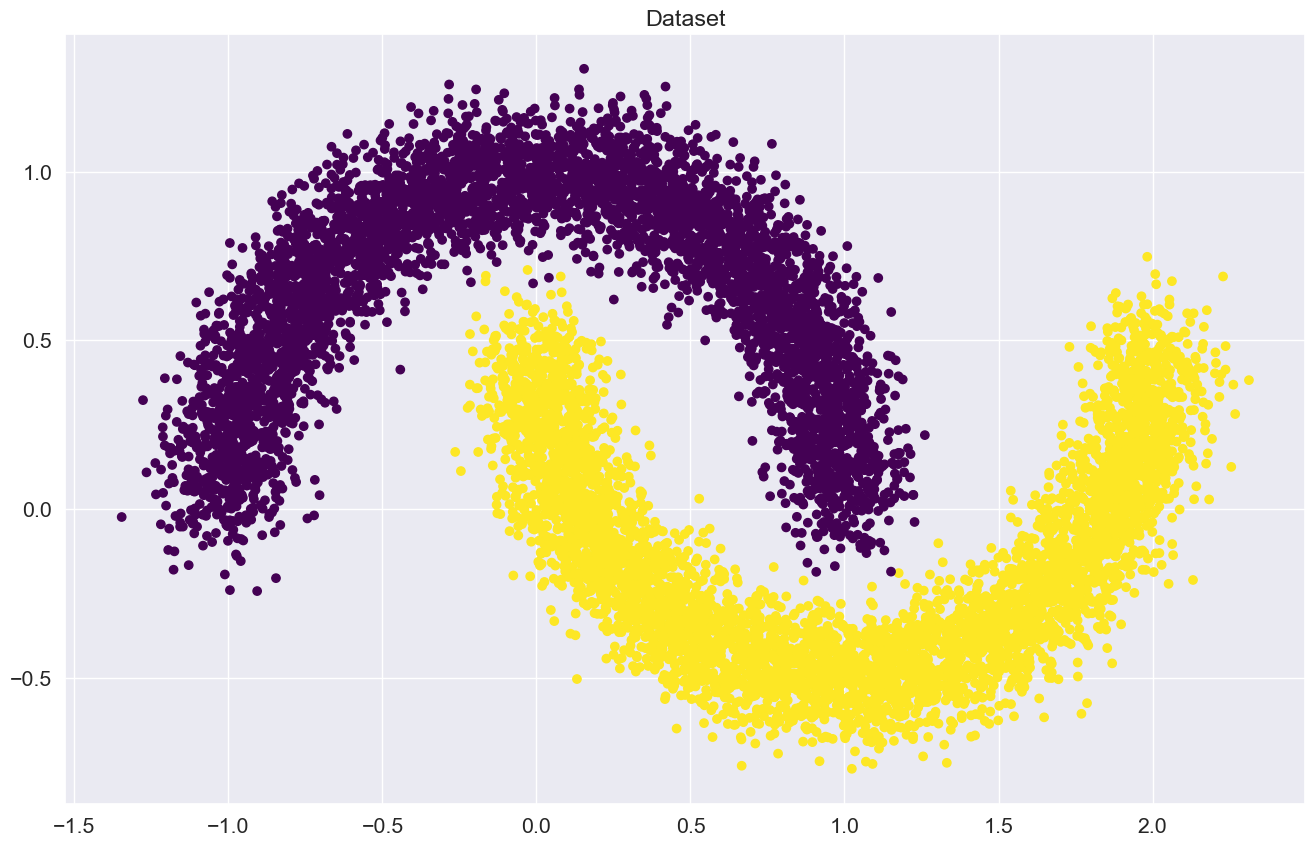

In [69]:
%matplotlib inline
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis");


Сделаем train/test split

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности Dataset и DataLoader.

Dataset загружает каждый объект по отдельности.

DataLoader группирует объекты из Dataset в батчи.

Так как наш датасет достаточно маленький мы будем использовать TensorDataset. Все, что нам нужно, это перевести из массива numpy в тензор с типом torch.float32.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [71]:
X_train_t =  torch.from_numpy(X_train).type(torch.float32) #.type(torch.float32)  # YOUR CODE GOES HERE
y_train_t =  torch.from_numpy(y_train).type(torch.float32)  # YOUR CODE GOES HERE
X_val_t =  torch.from_numpy(X_val).type(torch.float32)   # YOUR CODE GOES HERE
y_val_t =  torch.from_numpy(y_val).type(torch.float32)   # YOUR CODE GOES HERE

Создаем Dataset и DataLoader.

In [72]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Задание. Реализация логистической регрессии
Вам необходимо написать модуль на PyTorch реализующий 
l
o
g
i
t
s
=
X
W
+
b
, где 
W
 и 
b
 – параметры (nn.Parameter) модели. Иначе говоря, здесь мы реализуем своими руками модуль nn.Linear (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (torch.randn).

In [73]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((out_features, 1))) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [74]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Вопрос 1. Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [75]:
n_param = 0
for i in range(len(list(linear_regression.parameters()))):
    n_param += list(linear_regression.parameters())[i].size(0)
print('Количество параметров = ', n_param)

Количество параметров =  3


### Train loop
### Задание. Реализация цикла обучения

In [76]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) #Может, стоит применить outp.flatten()? # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch.view(outp.size())) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break  

Iteration: 0
Batch accuracy: 0.1484375
Iteration: 100
Batch accuracy: 0.421875
Iteration: 200
Batch accuracy: 0.71875
Iteration: 300
Batch accuracy: 0.796875
Iteration: 400
Batch accuracy: 0.765625
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8125

Iteration: 991.Convergence. Stopping iterations.


Вопрос 2. Сколько итераций потребовалось, чтобы алгоритм сошелся?

Ответ: 991

#### Визуализируем результаты

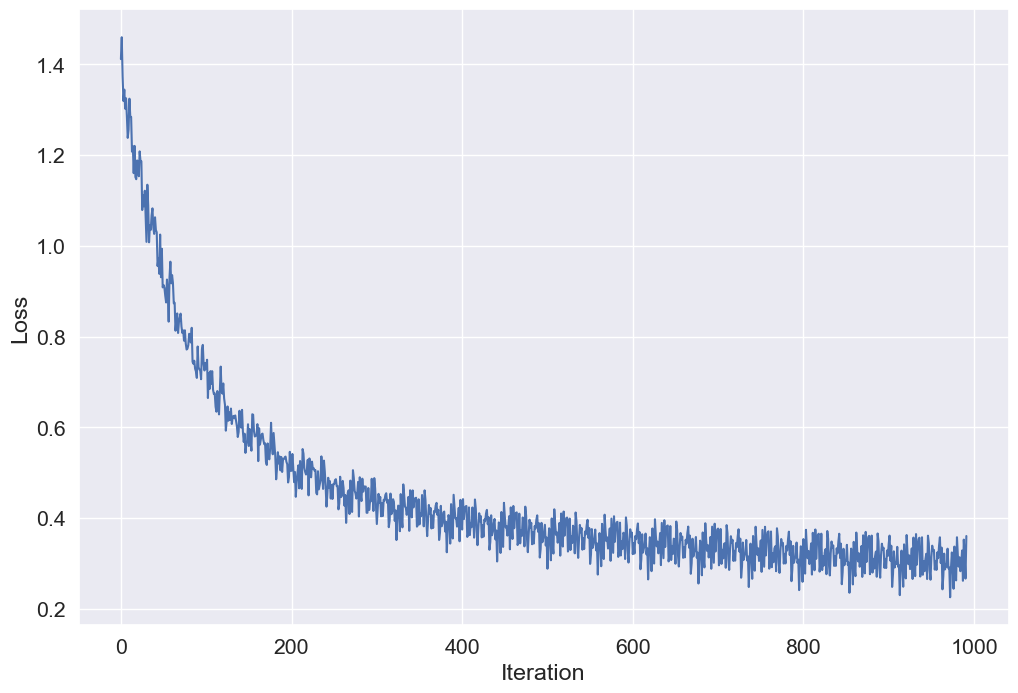

In [77]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

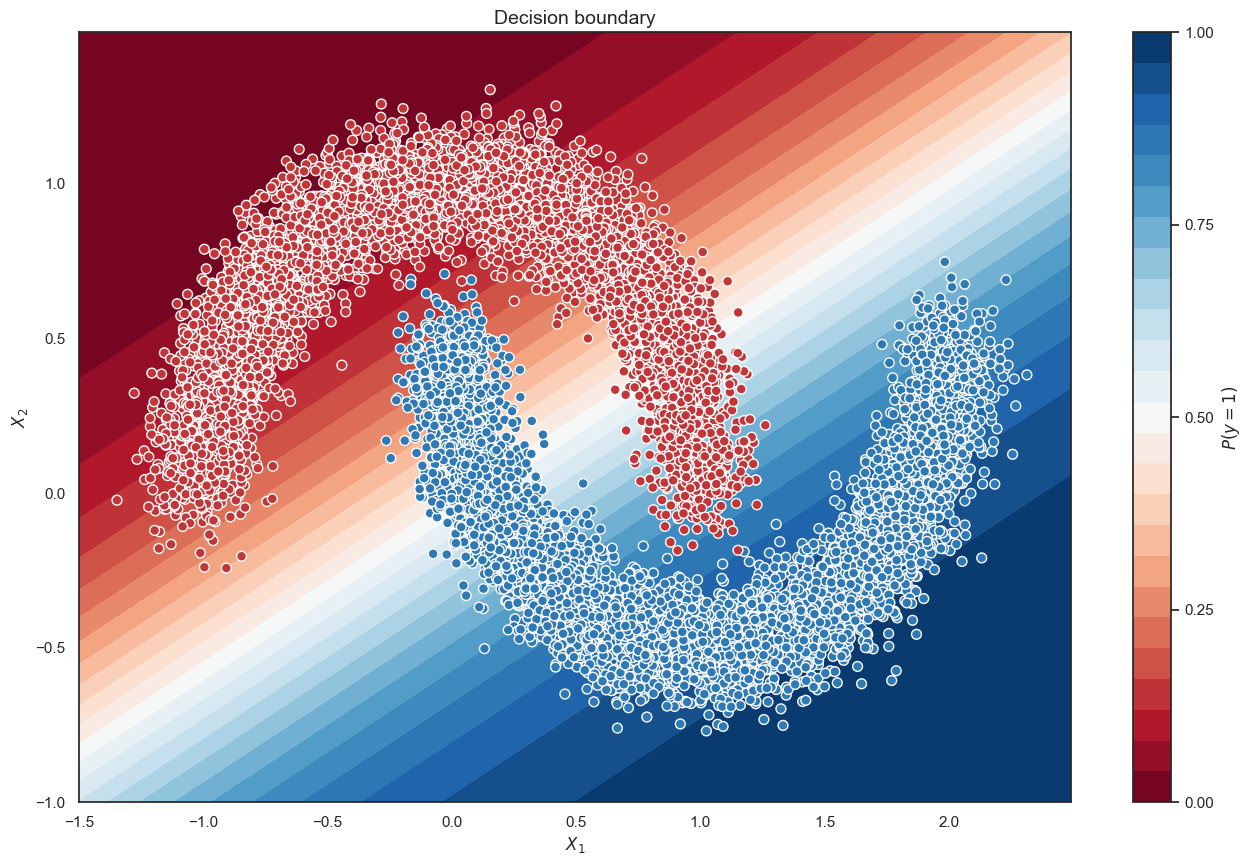

In [78]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [79]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        xx = torch.sigmoid(model(x_batch)) #<YOUR CODE>
       
        preds = xx > 0.5 #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [80]:
from sklearn.metrics import accuracy_score
y_pred = predict(val_dataloader, linear_regression)
print("Accuracy: ", accuracy_score(y_pred, y_val))

Accuracy:  0.8576


Вопрос 3

Какое accuracy получается после обучения?

Ответ: 0.8576

# Часть 2. Датасет MNIST

Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [81]:
!pip install torchvision


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [82]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size = 128) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size = 128) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети


Сначала решим MNIST с помощью полносвязной нейронной сети.

In [83]:
class Identical(nn.Module):
    def forward(self, x):
        return x

#### Задание. Простая полносвязная нейронная сеть
Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:

Уплощения матрицы в вектор (nn.Flatten);
Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
Выходного слоя с 10 нейронами.
Задайте лосс для обучения (кросс-энтропия).

In [84]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10),
    
    
    #YOUR CODE. Add layers to your sequential class
)

In [85]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)
### Задание. Дополните цикл обучения

In [87]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
          #  print('preds:', preds)
           # print('y_batch:', y_batch)
            correct = (preds == y_batch).flatten().type(torch.float32).sum() # ?????????КАК???????? # YOUR CODE GOES HERE
            all = len(y_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.87915
Loader: valid. Accuracy: 0.9258
Epoch: 2
Loader: train. Accuracy: 0.94215
Loader: valid. Accuracy: 0.9478
Epoch: 3
Loader: train. Accuracy: 0.9597333333333333
Loader: valid. Accuracy: 0.962
Epoch: 4
Loader: train. Accuracy: 0.9688
Loader: valid. Accuracy: 0.9669
Epoch: 5
Loader: train. Accuracy: 0.9741333333333333
Loader: valid. Accuracy: 0.9664
Epoch: 6
Loader: train. Accuracy: 0.9796166666666667
Loader: valid. Accuracy: 0.9684
Epoch: 7
Loader: train. Accuracy: 0.9829166666666667
Loader: valid. Accuracy: 0.9698
Epoch: 8
Loader: train. Accuracy: 0.9848666666666667
Loader: valid. Accuracy: 0.9706
Epoch: 9
Loader: train. Accuracy: 0.9860166666666667
Loader: valid. Accuracy: 0.9746
Epoch: 10
Loader: train. Accuracy: 0.9862833333333333
Loader: valid. Accuracy: 0.9741


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [88]:
elu_accuracy = accuracy["valid"]

In [89]:
elu_accuracy

[0.9258, 0.9478, 0.962, 0.9669, 0.9664, 0.9684, 0.9698, 0.9706, 0.9746, 0.9741]

In [90]:
def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10), 
    )
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    #loaders = {"train": train_dataloader, "valid": valid_dataloader}
    #device = "cuda" if torch.cuda.is_available() else "cpu"
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    
    
    #YOUR CODE. Add layers to your sequential class

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                     # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = (preds.flatten() == y_batch).type(torch.float32).sum() # ?????????КАК???????? # YOUR CODE GOES HERE
                #print('correct:', correct)
                all = len(y_batch) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                   # print('We are learning!')
                    loss = criterion(outp, y_batch)
                    #print('loss: ', loss)
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']    #YOUR CODE

In [91]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU) #YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.86295
Loader: valid. Accuracy: 0.8831
Epoch: 2
Loader: train. Accuracy: 0.8952166666666667
Loader: valid. Accuracy: 0.8994
Epoch: 3
Loader: train. Accuracy: 0.8999666666666667
Loader: valid. Accuracy: 0.8987
Epoch: 4
Loader: train. Accuracy: 0.9023
Loader: valid. Accuracy: 0.9001
Epoch: 5
Loader: train. Accuracy: 0.9041
Loader: valid. Accuracy: 0.9007
Epoch: 6
Loader: train. Accuracy: 0.90545
Loader: valid. Accuracy: 0.9008
Epoch: 7
Loader: train. Accuracy: 0.9067833333333334
Loader: valid. Accuracy: 0.9012
Epoch: 8
Loader: train. Accuracy: 0.9083166666666667
Loader: valid. Accuracy: 0.9013
Epoch: 9
Loader: train. Accuracy: 0.9094333333333333
Loader: valid. Accuracy: 0.9022
Epoch: 10
Loader: train. Accuracy: 0.9105166666666666
Loader: valid. Accuracy: 0.9034
Epoch: 1
Loader: train. Accuracy: 0.8680666666666667
Loader: valid. Accuracy: 0.9185
Epoch: 2
Loader: train. Accuracy: 0.9316166666666666
Loader: valid. Accuracy: 0.9423
Epoch: 3
Loader: train. A

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

Text(0.5, 0, 'Epoch')

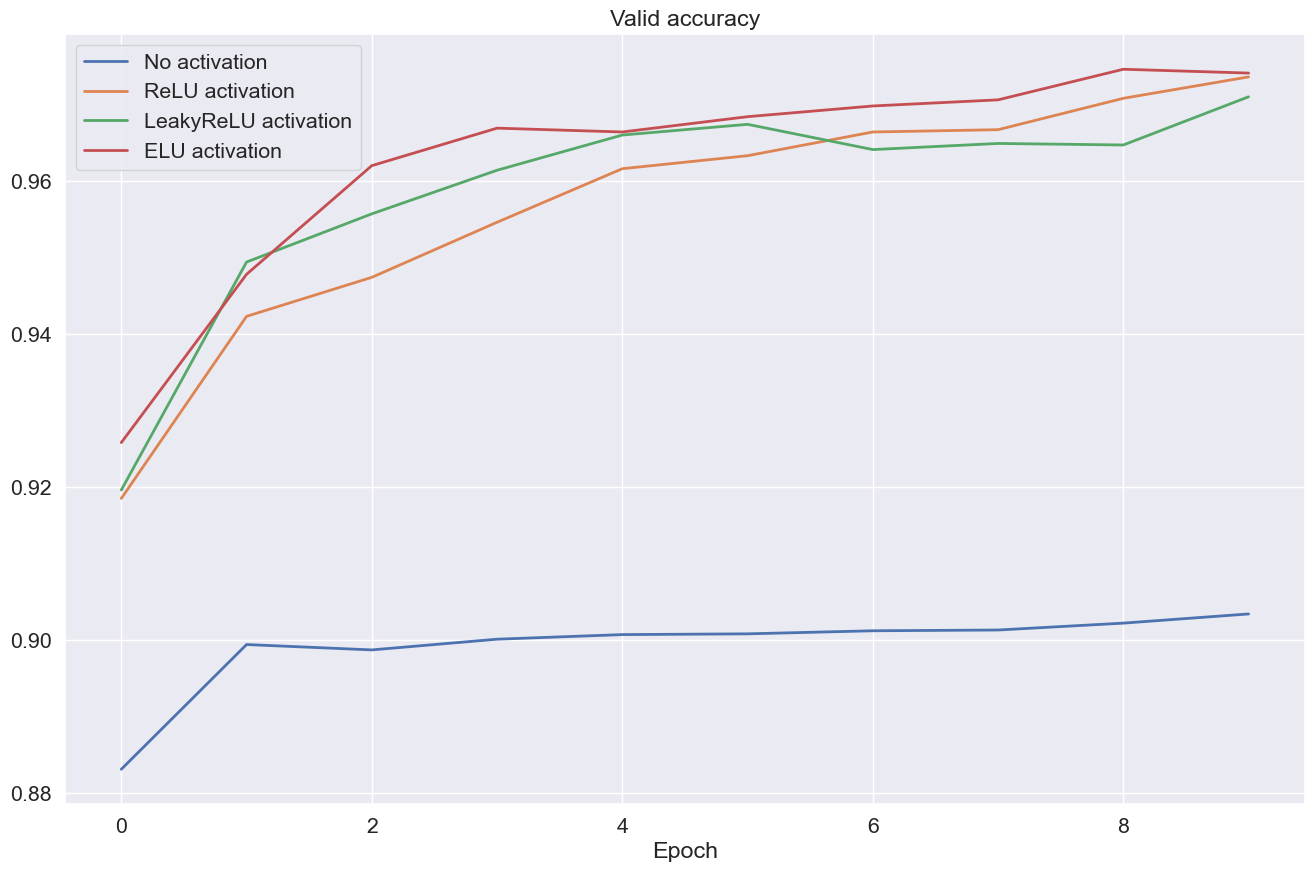

In [92]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
#plt.show()

Text(0.5, 0, 'Epoch')

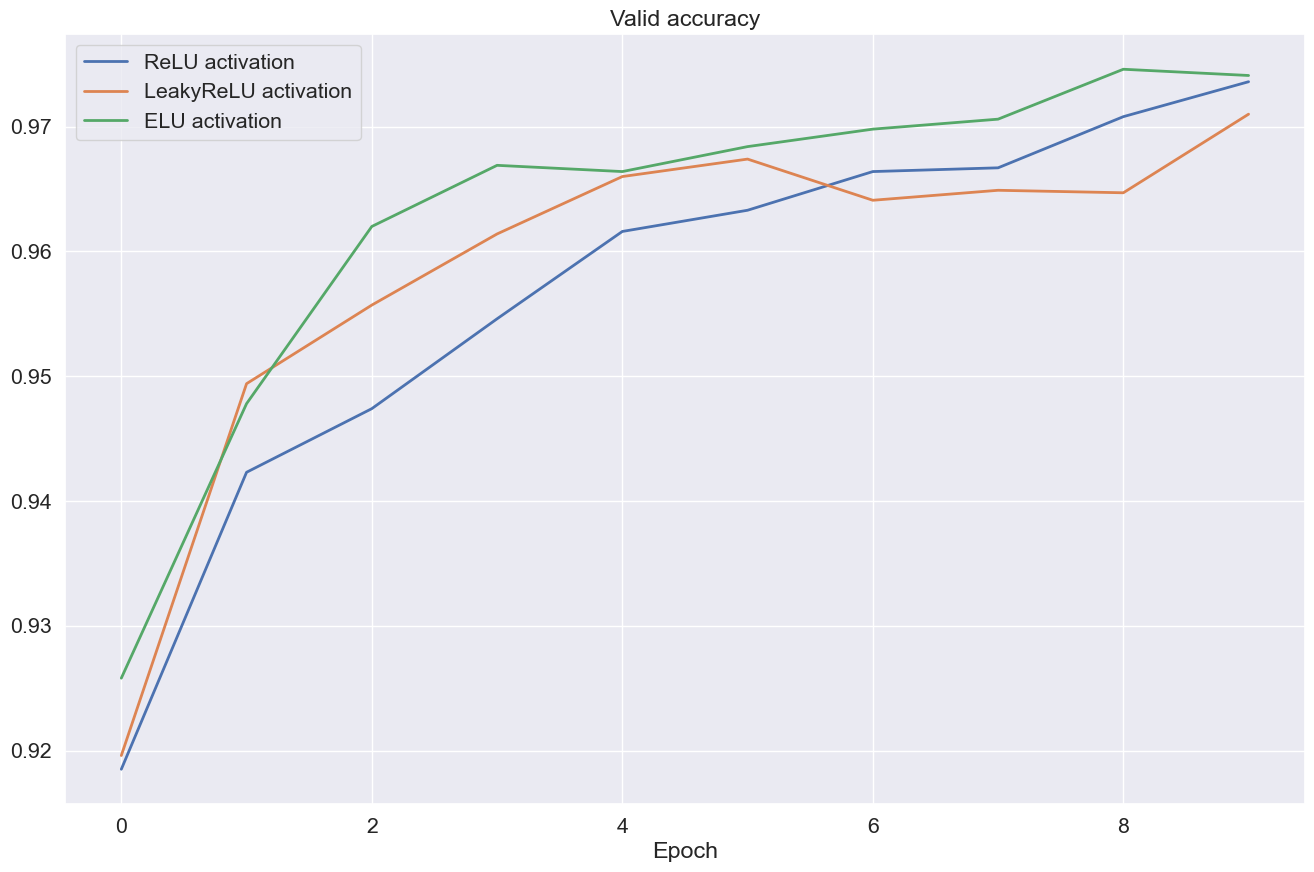

In [93]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")

Вопрос 4. Какая из активаций показала наивысший accuracy к концу обучения?

Ответ: ELU

## Часть 2.2 Сверточные нейронные сети



### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [94]:
pip install wget

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
import wget

In [96]:
!python -m wget -o sample_photo.jpg https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg


Saved under sample_photo (2).jpg


In [97]:
!pip install opencv-python


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


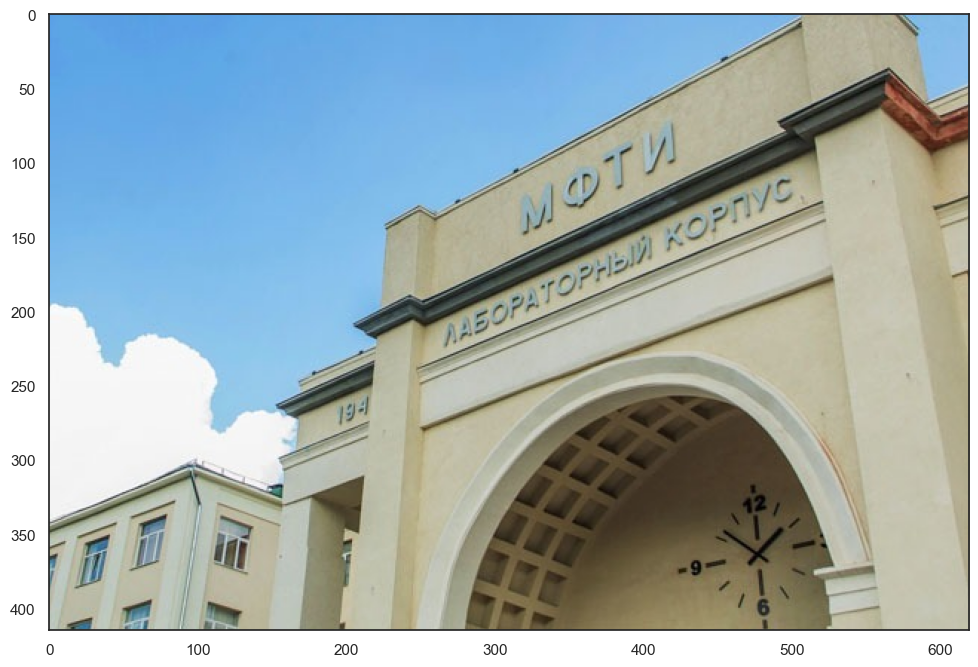

In [98]:
import cv2
import wget
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
#plt.show()

In [99]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

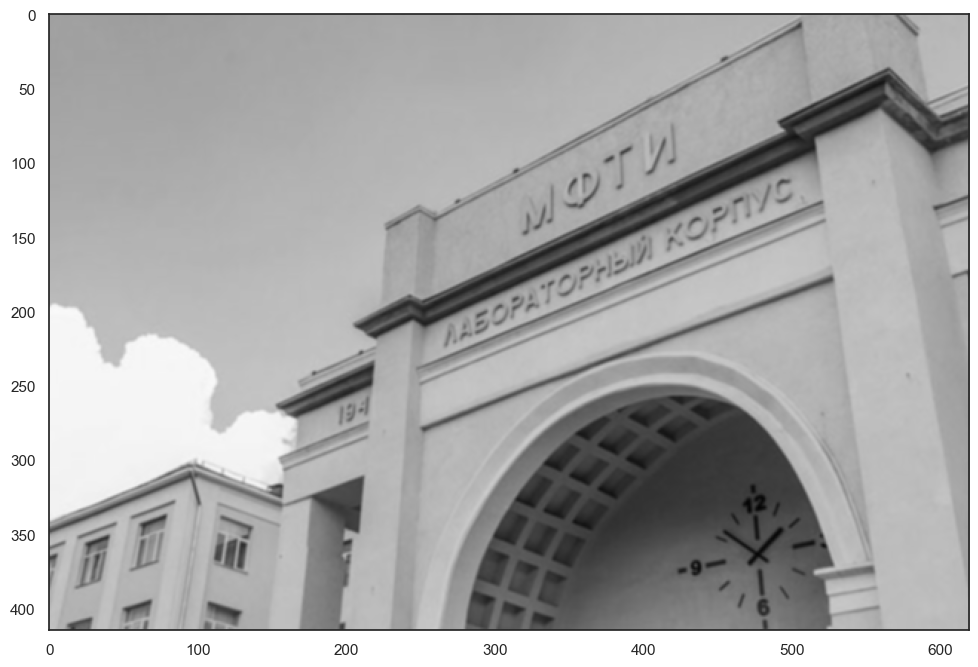

In [100]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)

Вопрос 5. Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1. Размытие

2. Увеличение резкости

3. Тождественное преобразование

4. Выделение вертикальных границ

5. Выделение горизонтальных границ

6. Выделение границ

Ответ: А) - 3, Б) - 5, В) - 4, Г) - 6, Д) - 2, Е) - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году! На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из

Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
MaxPooling-а 2x2;
Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
MaxPooling-а 2x2;
Уплощения (nn.Flatten);
Полносвязного слоя со 120 нейронами и активацией ReLU;
Полносвязного слоя с 84 нейронами и активацией ReLU;
Выходного слоя из 10 нейронов.

In [101]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(2, 2) #YOUR CODE
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #YOUR CODE  
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        #print('Shape:', x.shape)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [102]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [103]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        #dataloader.to(device)
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
          #  print('preds:', preds)
           # print('y_batch:', y_batch)
            correct = (preds == y_batch.to(device)).flatten().type(torch.float32).sum()  # YOUR CODE GOES HERE
            all = len(y_batch) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8773833333333333
Loader: valid. Accuracy: 0.9599
Epoch: 2
Loader: train. Accuracy: 0.9645833333333333
Loader: valid. Accuracy: 0.9744
Epoch: 3
Loader: train. Accuracy: 0.9757
Loader: valid. Accuracy: 0.9808
Epoch: 4
Loader: train. Accuracy: 0.9817166666666667
Loader: valid. Accuracy: 0.9829
Epoch: 5
Loader: train. Accuracy: 0.9851833333333333
Loader: valid. Accuracy: 0.9852
Epoch: 6
Loader: train. Accuracy: 0.9878666666666667
Loader: valid. Accuracy: 0.9852
Epoch: 7
Loader: train. Accuracy: 0.98985
Loader: valid. Accuracy: 0.9853
Epoch: 8
Loader: train. Accuracy: 0.9912833333333333
Loader: valid. Accuracy: 0.9855
Epoch: 9
Loader: train. Accuracy: 0.99205
Loader: valid. Accuracy: 0.9857
Epoch: 10
Loader: train. Accuracy: 0.993
Loader: valid. Accuracy: 0.9859


In [104]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

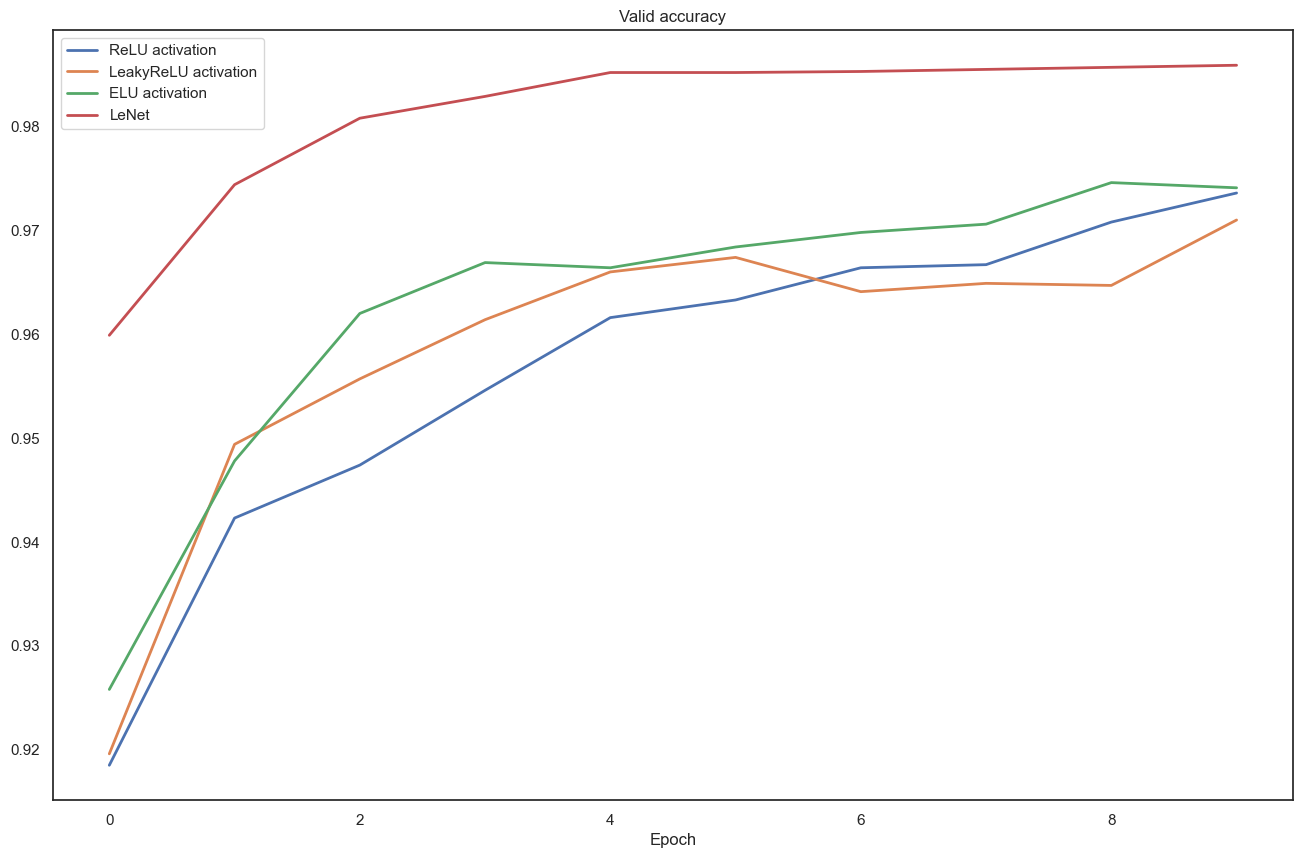

In [105]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Вопрос 6 Какое accuracy получается после обучения с точностью до двух знаков после запятой?

Ответ: 0.99